# Model where inputs are kept seperate

## Prep

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from time import time
from torch.utils.data import Dataset

In [2]:
def plot_accuracy_loss(training_results):
    plt.subplot(2, 1, 1)
    plt.plot(training_results['training_loss'], 'r')
    plt.ylabel('loss')
    plt.title('training loss iterations')
    plt.subplot(2, 1, 2)
    plt.plot(training_results['validation_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.show()

def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))
    plt.show()

def show_dataComp(data_sample,y):
    plt.subplot(1,2,1)
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(data_sample[1].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = ' + str(y))

    plt.show()

## Data Pairing

In [3]:
def indlist(target):
    indlist = [[],[],[],[],[]]
    
    for i in range(len(target)):
        if target[i] < 5:
            indlist[target[i]].append(i)
    return indlist

def subData(dataSet):
    #gets all the indices of the data obsv with same y from the dataset that is passed in only for 0-4
    indices = indlist(dataSet.targets)
    # a list of datasets where each dataset has the data for the same number
    subsets = []
    [subsets.append(torch.utils.data.Subset(dataSet, i)) for i in indices]
    return subsets
    

In [4]:
def comparisonDataConsecutive(dataSet):
    subsets = subData(dataSet)
    # a list of the size of the possible pairs
    comp = []
    for indi in range(len(subsets) - 1):
        comp.append(int(min(len(subsets[indi]), len(subsets[indi + 1]))))
    tot1 = sum(comp)
    # img pair data stored
    x = torch.zeros([tot1, 2, 28, 28], dtype=torch.float32)
    # greater than or less than label stored
    y = torch.zeros([tot1,1])
    # 1 for first pic greater, 0 for first pic less
    k = 0
    # does the actual pairing
    for i in range(len(subsets) - 1):
        for j in range(int(comp[i] / 2)):
            x[k][0] = subsets[i][j][0]
            x[k][1] = subsets[i + 1][j][0]
            y[k][0] = 0
            k += 1
        for j in range(int(comp[i] / 2), comp[i]):
            x[k][1] = subsets[i][j][0]
            x[k][0] = subsets[i + 1][j][0]
            y[k][0] = 1
            k += 1
    return x,y

In [5]:
def comparisonDataNonconsecutive(dataSet):
    subsets = subData(dataSet)
    # a dictionary of pairs and the size of the pairings
    comp = {}
    
    for i in range(len(subsets) - 2):
        for j in range(i + 2, len(subsets), 1):
            comp[(i, j)] = int(min(len(subsets[i]), len(subsets[j])))
    tot = sum(comp.values())
    # greater than or less than label stored
    x = torch.zeros([tot, 2, 28, 28], dtype=torch.float32)
    # 1 for first pic greater, 0 for first pic less
    y = torch.zeros([tot, 1])
    k = 0
    #the pairing
    for key, values in comp.items():
        for value in range(int(values / 2)):
            x[k][0] = subsets[key[0]][value][0]
            x[k][1] = subsets[key[1]][value][0]
            y[k][0] = 0
            k += 1
        for value in range(int(values / 2), values):
            x[k][0] = subsets[key[1]][value][0]
            x[k][1] = subsets[key[0]][value][0]
            y[k][0] = 1
            k += 1
    return x,y


In [6]:
def comparisonAll(dataSet):
    subsets = subData(dataSet)
    # a dictionary of pairs(tuple) and the size of the pairings
    comp = {}
    for i in range(len(subsets) - 1):
        for j in range(i + 1, len(subsets), 1):
            comp[(i, j)] = int(min(len(subsets[i]), len(subsets[j])))
    #print(len(comp.keys()))
    #print(comp.keys())
    tot = sum(comp.values())
    # greater than or less than label stored
    x = torch.zeros([tot, 2, 28, 28], dtype=torch.float32)
    # 1 for first pic greater, 0 for first pic less
    y = torch.zeros([tot, 1])
    z = list()
    k = 0
    # the pairining
    for key, values in comp.items():
        for value in range(int(values / 2)):
            x[k][0] = subsets[key[0]][value][0]
            x[k][1] = subsets[key[1]][value][0]
            y[k][0] = 0
            z.append(key)
            k += 1
        for value in range(int(values / 2), values):
            x[k][0] = subsets[key[1]][value][0]
            x[k][1] = subsets[key[0]][value][0]
            y[k][0] = 1
            a = key[0]
            b = key[1]
            c = (b,a)
            z.append(c)
            k += 1
    return x,y,z

In [7]:
class Trainsetcomp(Dataset):
    def __init__(self, x, y):
        self.len = (x.shape[0])
        self.x = x
        self.y = y 

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return self.len
    
class TrainsetcompwithA(Dataset):
    def __init__(self, x, y, z):
        self.len = (x.shape[0])
        self.x = x
        self.y = y 
        #the pair
        self.z = z

    def __getitem__(self, index):
        return (self.x[index], self.y[index], self.z[index])

    def __len__(self):
        return self.len

In [8]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),])

trainset = dsets.MNIST(root='./../data',
                            train=True,
                            download=True,
                            transform=transform)
valset = dsets.MNIST(root='./../data',
                            train=False,
                            download=True,
                            transform=transform)

In [9]:
x, y = comparisonDataConsecutive(trainset)
traindataComp = Trainsetcomp(x,y)
x,y = comparisonDataConsecutive(valset)
valdataComp = Trainsetcomp(x,y)

In [10]:
trainloader = torch.utils.data.DataLoader(traindataComp,
                                          batch_size=64,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(valdataComp,
                                          batch_size=64,
                                          shuffle=True)
x,y,z = comparisonAll(valset)
testdata = TrainsetcompwithA(x,y,z)
testloader = torch.utils.data.DataLoader(testdata,
                                          batch_size=64,
                                          shuffle=F)
# in the test loader: z is a list of size 2 of two [64] shape tensors. - it turned the tuple into a list of tensors

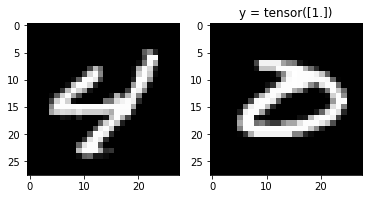

tensor(4) tensor(0)


In [11]:
## showing what the z in the test loader is- ignore
i = 1
j = 0
for x,y,z in testloader:
    j+=1
    p = x[i,:,:,:]
    show_dataComp(p,y[i,:])
    #print(z)
    print(z[0][i],z[1][i])
    if j >= 1:
        break

## Model

In [12]:
ind = 784
hlayers1 = [128,64,10]
hlayer2 = 32
outd = 1

In [152]:
class Model(nn.Module):
    
    def __init__(self, ind, hlayers1, hlayers2, outd):
        super(Model, self).__init__()
        self.net1lin1 = nn.Linear(ind, hlayers1[0])
        self.net1lin2 = nn.Linear(hlayers1[0], hlayers1[1])
        self.net1lin3 = nn.Linear(hlayers1[1], hlayers1[2])
        
        self.net2lin1 = nn.Linear(ind, hlayers1[0])
        self.net2lin2 = nn.Linear(hlayers1[0], hlayers1[1])
        self.net2lin3 = nn.Linear(hlayers1[1], hlayers1[2])
        
        self.agg1 = nn.Linear(2*hlayers1[2], hlayers2)
        self.agg2 = nn.Linear(hlayers2, outd)
        self.n1l1 = []
        self.n1l2 = []
        self.n1l3 = []
        self.n2l1 = []
        self.n2l2 = []
        self.n2l3 = []
        self.ac1 = []
        self.pairs = []
        
    def forward(self, x, recActivations = False):
        if recActivations:
            if len(list(x.shape)) < 4:
                x1 = x[0].view(-1,784)
                #print(x[1])
                x2 = x[1].view(-1,784)
                #print(x1.shape)
            else:
                x1 = x[:,0,:,:]
                x1 = x1.view(x1.shape[0],784)
                x2 = x[:,1,:,:]
                x2 = x2.view(x2.shape[0],784)
                
            
            a1 = torch.relu(self.net1lin1(x1))
            self.n1l1.append(a1)
            a2 = torch.relu(self.net1lin2(a1))
            self.n1l2.append(a2)
            a3 = torch.relu(self.net1lin3(a2))
            self.n1l3.append(a3)
            
            
            b1 = torch.relu(self.net2lin1(x2))
            self.n2l1.append(b1)
            b2 = torch.relu(self.net2lin2(b1))
            self.n2l2.append(b2)
            b3 = torch.relu(self.net2lin3(b2))
            self.n2l3.append(b3)
            
            c = torch.cat((a3,b3),1)
            #print(c.shape)
            #c = torch.cat((a3,b3),0).view(-1)
            c1 = torch.relu(self.agg1(c))
            self.ac1.append(c1)
            c2 = torch.sigmoid(self.agg2(c1))
            
            return c2
            
        else:
            
            if len(list(x.shape)) < 4:
                x1 = x[0].view(-1,784)
                #print(x[1])
                x2 = x[1].view(-1,784)
                #print(x1.shape)
            else:
                x1 = x[:,0,:,:]
                x1 = x1.view(x1.shape[0],784)
                x2 = x[:,1,:,:]
                x2 = x2.view(x2.shape[0],784)
                
            
            a1 = torch.relu(self.net1lin1(x1))
            a2 = torch.relu(self.net1lin2(a1))
            a3 = torch.relu(self.net1lin3(a2))
            
            
            b1 = torch.relu(self.net2lin1(x2))
            b2 = torch.relu(self.net2lin2(b1))
            b3 = torch.relu(self.net2lin3(b2))
            
            c = torch.cat((a3,b3),1)
            #print(c.shape)
            #c = torch.cat((a3,b3),0).view(-1)
            c1 = torch.relu(self.agg1(c))
            c2 = torch.sigmoid(self.agg2(c1))
            
            return c2
        
    def setPair(self, pair):
        self.pairs.append(pair)


In [153]:
#x = testdata[0][0]
#show_dataComp(x, testdata[0][1])

In [158]:
model = Model(ind,hlayers1,hlayer2,outd)
#a = model(testdata[0][0])
#a

In [159]:
def train(model, criterion, optimizer, epochs = 30):
    lossList = []
    #time0 = time()
    for i in range(epochs):
        runningLoss = 0
        for x, y in trainloader:
            optimizer.zero_grad()
            yhat = model(x)
            #print(yhat.shape)
            #print(y.shape)
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()
            runningLoss += loss.item()
        print('epoch ', i, ' loss: ', str(runningLoss / len(traindataComp)))
        lossList.append(runningLoss / len(traindataComp))
    return lossList

In [160]:
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.03)
results = train(model,criterion,optimizer,25)

epoch  0  loss:  0.01078224211829291
epoch  1  loss:  0.009304856167698997
epoch  2  loss:  0.00633980419995978
epoch  3  loss:  0.0038838029684977564
epoch  4  loss:  0.0027306694482342225
epoch  5  loss:  0.0021493029999152054
epoch  6  loss:  0.001877368435953916
epoch  7  loss:  0.0015559985848377068
epoch  8  loss:  0.0014340320403522597
epoch  9  loss:  0.0012178708317849938
epoch  10  loss:  0.0011382634119854265
epoch  11  loss:  0.0009915686499494642
epoch  12  loss:  0.0008912135568157132
epoch  13  loss:  0.0008532937036338833
epoch  14  loss:  0.0007531027160091755
epoch  15  loss:  0.0006678331220608022
epoch  16  loss:  0.001117653732686841
epoch  17  loss:  0.0005739479014913641
epoch  18  loss:  0.0005253707933968817
epoch  19  loss:  0.0005293017159915394
epoch  20  loss:  0.0004304711219262466
epoch  21  loss:  0.0003580654589960693
epoch  22  loss:  0.0003578098253531011
epoch  23  loss:  0.0003655740186951007
epoch  24  loss:  0.0002992712769554806


In [161]:
totcount = 0
correctcount = 0
for x,y in valloader:
    with torch.no_grad():
        yhat = model(x)
    ones = torch.ones(yhat.shape)
    yhat = torch.where(yhat>.5, ones, yhat)
    z = torch.zeros(yhat.shape)
    yhat = torch.where(yhat<0.5, z, yhat)
    wrongC = 0
    for i in range(len(y)):
        #print(i)
        if yhat[i][0] == y[i][0]:
            correctcount+=1
            #p = torch.reshape(x[i], (2,28,28))
            #show_dataComp(p, y[i])
            
        else:
            #if wrongC < 2:
                #p = torch.reshape(x[i], (2,28,28))
                #show_dataComp(p, yhat[i])
            wrongC += 1
        totcount+=1
print(correctcount)
print(totcount)
print('val set accuracy: ', correctcount/totcount)


3926
4004
val set accuracy:  0.9805194805194806


In [162]:
totcount = 0
correctcount = 0
for x,y,z in testloader:
    with torch.no_grad():
        yhat = model(x,True)
    model.setPair(z)
    ones = torch.ones(yhat.shape)
    yhat = torch.where(yhat>.5, ones, yhat)
    z = torch.zeros(yhat.shape)
    yhat = torch.where(yhat<0.5, z, yhat)
    wrongC = 0
    for i in range(len(y)):
        #print(i)
        if yhat[i][0] == y[i][0]:
            correctcount+=1
            #p = torch.reshape(x[i], (2,28,28))
            #show_dataComp(p, y[i])
            
        else:
            #if wrongC < 2:
                #p = torch.reshape(x[i], (2,28,28))
                #show_dataComp(p, yhat[i])
            wrongC += 1
        totcount+=1
print(correctcount)
print(totcount)
print('test set accuracy: ', correctcount/totcount)

9825
9918
test set accuracy:  0.9906231094978827


In [171]:
#print(len(testdata))
#print(len(testloader)*64)
#print(len(model.n1l3))
#print(len(model.pairs))
print(model.pairs[0])

9918
9920
155
155
[tensor([0, 3, 0, 2, 0, 2, 1, 0, 4, 0, 1, 0, 4, 1, 0, 2, 0, 1, 0, 1, 2, 3, 0, 2,
        4, 3, 2, 4, 1, 4, 4, 0, 4, 0, 3, 0, 3, 1, 1, 2, 3, 0, 3, 2, 4, 4, 0, 3,
        0, 2, 0, 0, 3, 4, 4, 1, 1, 2, 4, 1, 2, 3, 2, 3]), tensor([3, 1, 3, 3, 1, 4, 3, 1, 1, 4, 0, 2, 1, 0, 4, 0, 1, 0, 2, 0, 1, 4, 3, 4,
        0, 0, 1, 0, 2, 2, 0, 1, 3, 1, 0, 4, 0, 4, 2, 4, 2, 4, 0, 0, 0, 0, 3, 2,
        2, 1, 3, 4, 2, 3, 0, 3, 0, 3, 1, 2, 4, 2, 4, 4])]


## RSA Preprocess

In [186]:
# last layer-  before the inputs are combined
net1 = {0:[],1:[],2:[],3:[],4:[]}
net2 = {0:[],1:[],2:[],3:[],4:[]}

for num,n1,n2 in zip(model.pairs, model.n1l3, model.n2l3):
    #print(num)
    for i in range( len(num[0])):
        nn1 = num[0][i].item()
        nn2 = num[1][i].item()
        net1[nn1].append(n1[i].numpy())
        net2[nn2].append(n2[i].numpy())
for key in net1.keys():
        rep = np.array(net1[key])
        net1[key] = rep
for key in net2.keys():
        rep = np.array(net2[key])
        net2[key] = rep

net2
tota = 0
for key in net1.keys():
    #print(key)
    tota +=len(net1[key])
tota   
# I avg over this- should i calculate variation?

9918

In [211]:
def mkAvgDict(activationsDict):
    avgDict = {}
    for key in activationsDict:
        a = np.mean(activationsDict[key], axis=0)
        avgDict[key] = a
    return avgDict
avgnet1 = mkAvgDict(net1)
avgnet2 = mkAvgDict(net2)
avgnet12 = {}
for i in range(5):
    avgnet12[i] = (avgnet1[i] + avgnet2[i])/2
avgnet1

{0: array([0.        , 0.02270868, 0.02743165, 3.451298  , 2.5189776 ,
        3.482485  , 0.00465766, 0.0130514 , 0.01158277, 0.01553226],
       dtype=float32),
 1: array([0.        , 0.20562018, 0.14403307, 1.5850787 , 1.0635128 ,
        0.01352642, 0.01018519, 0.01603615, 0.00397547, 0.0080237 ],
       dtype=float32),
 2: array([0.        , 1.4192814 , 0.22724456, 1.0606575 , 0.42853016,
        0.01307661, 0.04057226, 0.01495758, 0.15296236, 0.35492963],
       dtype=float32),
 3: array([0.        , 2.3825645 , 0.5016595 , 0.84653896, 0.02495121,
        0.00886979, 0.00646071, 0.00537598, 0.82254267, 1.1911602 ],
       dtype=float32),
 4: array([0.        , 4.8758907 , 2.2331488 , 0.02512791, 0.01675991,
        0.05968692, 0.        , 0.00879957, 3.3590903 , 3.2235193 ],
       dtype=float32)}

In [222]:
avgnet1m = np.vstack((avgnet1[0],avgnet1[1],avgnet1[2],avgnet1[3],avgnet1[4]))
avgnet2m = np.vstack((avgnet2[0],avgnet2[1],avgnet2[2],avgnet2[3],avgnet2[4]))
avgnet12m = np.vstack((avgnet12[0],avgnet12[1],avgnet12[2],avgnet12[3],avgnet12[4]))
def mkUnitbyRow(matrix):
    unitMatrix = np.empty(list(matrix.shape))
    for i in range(5):
        unitMatrix[i] =  matrix[i]/np.linalg.norm(matrix[i])
    return unitMatrix
avgnet1m = mkUnitbyRow(avgnet1m)
avgnet2m = mkUnitbyRow(avgnet2m)
avgnet12m = mkUnitbyRow(avgnet12m)

## RSA


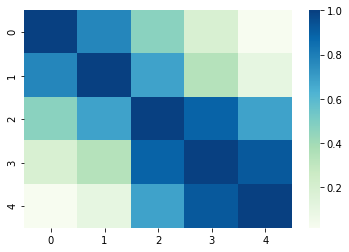

In [223]:
x = list(range(5))
sim1= np.matmul(avgnet1m,np.transpose(avgnet1m))
hm = sns.heatmap(sim1, xticklabels=x, yticklabels=x, cmap="GnBu")

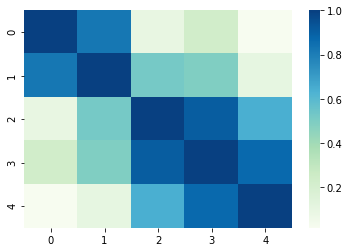

In [224]:
sim2= np.matmul(avgnet2m,np.transpose(avgnet2m))
hm = sns.heatmap(sim2, xticklabels=x, yticklabels=x, cmap="GnBu")

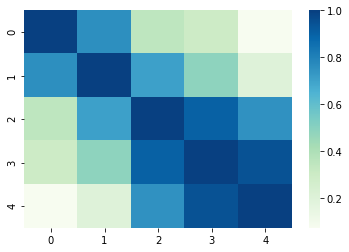

In [225]:
sim3= np.matmul(avgnet12m,np.transpose(avgnet12m))
hm = sns.heatmap(sim3, xticklabels=x, yticklabels=x, cmap="GnBu")